In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
plt.rcParams['figure.figsize'] = (14, 6)

In [4]:
path_eth = "data/ethereum-historical-data.csv"
path_sol = "data/solana-historical-data.csv"
path_usdt = "data/tether-historical-data.csv"
path_btc = "data/btcusd_1-min_data.csv"

In [5]:
def load_crypto_ru_csv(path, name_col_prefix):
    df = pd.read_csv(path)

    # Переименовываю колонки на английский
    rename_cols = {
        'Дата': 'Date',
        'Открытие': f'{name_col_prefix}_Open',
        'Макс': f'{name_col_prefix}_High',
        'Мин': f'{name_col_prefix}_Low',
        'Средняя': f'{name_col_prefix}_Avg',
        'Закрыть': f'{name_col_prefix}_Close',
        'Объём': f'{name_col_prefix}_Volume',
        'Капитализ.': f'{name_col_prefix}_MCap',
        'Изм.': f'{name_col_prefix}_ChangePct'
    }
    df = df.rename(columns=rename_cols)

    df['Date'] = pd.to_datetime(df['Date'])

    # Функция очистки чисел вида "$2,509" или "2.180"
    def to_float(x):
        if isinstance(x, str):
            x = x.replace('$', '').replace(',', '')
        try:
            return float(x)
        except:
            return np.nan

    num_cols = [c for c in df.columns if c != 'Date']
    for c in num_cols:
        df[c] = df[c].apply(to_float)

    df = df.sort_values('Date').reset_index(drop=True)
    return df

In [6]:
eth = load_crypto_ru_csv(path_eth, 'ETH')
sol = load_crypto_ru_csv(path_sol, 'SOL')
usdt = load_crypto_ru_csv(path_usdt, 'USDT')
btc = pd.read_csv(path_btc)

In [7]:
btc['DateTime'] = pd.to_datetime(btc['Timestamp'], unit='s')
btc['Date'] = btc['DateTime'].dt.floor('D')

# Ресемплинг: берём дневные данные + суммарный объём
btc_daily = (
    btc
    .groupby('Date')
    .agg(
        BTC_Open=('Open', 'first'),
        BTC_High=('High', 'max'),
        BTC_Low=('Low', 'min'),
        BTC_Close=('Close', 'last'),
        BTC_Volume=('Volume', 'sum')
    )
    .reset_index()
    .sort_values('Date')
)

In [8]:
dfs = [eth[['Date', 'ETH_Close', 'ETH_Volume']],
       sol[['Date', 'SOL_Close', 'SOL_Volume']],
       usdt[['Date', 'USDT_Close', 'USDT_Volume']]]

dfs.append(btc_daily[['Date', 'BTC_Close', 'BTC_Volume']])

from functools import reduce
full = reduce(lambda left, right: pd.merge(left, right, on='Date', how='inner'), dfs)

full = full.set_index('Date').sort_index()
full.head()

,ETH_Close,ETH_Volume,SOL_Close,SOL_Volume,USDT_Close,USDT_Volume,BTC_Close,BTC_Volume
Date,,,,,,,,
2022-06-09,1786.0,3.517858e+09,39.90,8.450835e+08,0.999,1.439351e+10,29990.88,967.428486
2022-06-10,1658.0,5.942350e+09,37.04,7.844755e+08,0.999,1.723082e+10,28937.05,2512.622358
2022-06-11,1524.0,6.923228e+09,33.81,7.117197e+08,0.999,1.636120e+10,28571.03,1665.995847
2022-06-12,1439.0,7.525554e+09,30.71,9.598438e+08,0.999,2.057387e+10,27387.23,2182.012839
2022-06-13,1199.0,1.663284e+10,27.97,1.689254e+09,0.999,4.185709e+10,23144.08,11560.651179


In [9]:
# Лог-доходности
price_cols = [c for c in full.columns if c.endswith('_Close')]
returns = np.log(full[price_cols]).diff().dropna()
returns.head()

,ETH_Close,SOL_Close,USDT_Close,BTC_Close
Date,,,,
2022-06-10,-0.074366,-0.074378,0.0,-0.035771
2022-06-11,-0.084274,-0.091242,0.0,-0.012730
2022-06-12,-0.057390,-0.096168,0.0,-0.042316
2022-06-13,-0.182461,-0.093456,0.0,-0.168338
2022-06-14,0.008306,0.059341,0.0,-0.043460


Корреляции рассчитываются **по логарифмическим доходностям**, а не по самим ценам, что является стандартным подходом в анализе временных рядов и финансах, так как:
- цены нестационарны,
- корреляция цен часто является ложной из-за общего тренда,
- доходности отражают реальную синхронность движений.

  Для анализа используются три метода корреляции:
1. **Пирсона (Pearson)**
2. **Спирмена (Spearman)**
3. **Кендалла (Kendall)**

## 1. Корреляция Пирсона (Pearson)

### Что измеряет

Корреляция Пирсона измеряет **линейную зависимость** между двумя временными рядами.

Характеристики:
- чувствительна к выбросам,
- предполагает линейную форму зависимости,
- широко используется в финансовом анализе.

### Когда применять

- если ожидается линейная зависимость,
- для базовой оценки связи между активами.

### Результаты и интерпретация

- **ETH - SOL** — сильная положительная корреляция (~0.70)
- **ETH - BTC** — сильная корреляция (~0.69)
- **SOL - BTC** — умеренная корреляция (~0.56)
- **USDT - остальные активы** — корреляция близка к нулю

### Вывод

ETH и SOL движутся синхронно.  
BTC оказывает значительное влияние, но не является единственным драйвером.  
USDT практически не зависит от рыночных движений.

In [10]:
corr_pearson = returns.corr(method='pearson')
print("Pearson correlation:")
print(corr_pearson)

Pearson correlation:
            ETH_Close  SOL_Close  USDT_Close  BTC_Close
ETH_Close    1.000000   0.701640    0.068075   0.694434
SOL_Close    0.701640   1.000000    0.046116   0.566327
USDT_Close   0.068075   0.046116    1.000000   0.012985
BTC_Close    0.694434   0.566327    0.012985   1.000000


## 2️. Корреляция Спирмена (Spearman)

### Что измеряет

Корреляция Спирмена оценивает **монотонную зависимость** между рядами, основываясь на рангах значений.

Характеристики:
- устойчива к выбросам,
- выявляет нелинейные зависимости,
- анализирует направление движения, а не амплитуду.

### Когда применять

- при неизвестной форме зависимости,
- при наличии шума и выбросов в данных.

### Результаты и интерпретация

- **ETH - SOL** — сильная зависимость (~0.70)
- **ETH - BTC** — сильная зависимость (~0.66)
- **SOL - BTC** — умеренная зависимость (~0.58)
- **USDT - остальные активы** — слабая зависимость (~0.11–0.16)

### Вывод

Направления движений ETH, SOL и BTC в большинстве случаев совпадают.  
USDT демонстрирует лишь слабую реакцию на рынок.

In [11]:
corr_spearman = returns.corr(method='spearman')
print("\nSpearman correlation:")
print(corr_spearman)


Spearman correlation:
            ETH_Close  SOL_Close  USDT_Close  BTC_Close
ETH_Close    1.000000   0.698989    0.140768   0.659560
SOL_Close    0.698989   1.000000    0.118751   0.579258
USDT_Close   0.140768   0.118751    1.000000   0.160285
BTC_Close    0.659560   0.579258    0.160285   1.000000


## 3. Корреляция Кендалла (Kendall)

### Что измеряет

Корреляция Кендалла показывает вероятность того, что два временных ряда **движутся в одном направлении**.

Характеристики:
- самый консервативный метод,
- устойчив к шуму,
- хорошо подходит для финансовых временных рядов.

### Когда применять

- при высоком уровне шума,
- для надёжной оценки зависимости.

### Результаты и интерпретация

- **ETH - SOL** — умеренная корреляция (~0.53)
- **ETH - BTC** — умеренная корреляция (~0.49)
- **SOL - BTC** — слабая–умеренная корреляция (~0.42)
- **USDT - остальные активы** — слабая корреляция (~0.10–0.13)

### Вывод

Связь между активами существует, но она менее стабильна, чем показывает корреляция Пирсона.

In [12]:
corr_kendall = returns.corr(method='kendall')
print("\nKendall correlation:")
print(corr_kendall)


Kendall correlation:
            ETH_Close  SOL_Close  USDT_Close  BTC_Close
ETH_Close    1.000000   0.528641    0.114028   0.486761
SOL_Close    0.528641   1.000000    0.095935   0.421227
USDT_Close   0.114028   0.095935    1.000000   0.129925
BTC_Close    0.486761   0.421227    0.129925   1.000000


## Общие выводы

1. **ETH и SOL сильно взаимосвязаны**
   - оправдано использование обоих активов как признаков в ML-моделях
2. **BTC оказывает существенное влияние на рынок**
   - полезен как дополнительный фактор
3. **USDT не является драйвером цены**
   - может использоваться как индикатор рыночной стабильности
4. Использование нескольких методов корреляции повышает надёжность анализа

In [14]:
def make_lag_features(df, target_col, lag_days=30):
    """
    df — DataFrame с индексом Date и колонками закрытий/объёмов
    target_col — что прогнозируем (например, 'ETH_Close')
    lag_days — сколько лагов по каждому признаку
    """
    # исходные признаки
    base = df.copy()

    # сюда соберём все лаги как отдельные Series
    lag_cols = {}

    for col in df.columns:
        for lag in range(1, lag_days + 1):
            lag_name = f'{col}_lag{lag}'
            lag_cols[lag_name] = df[col].shift(lag)

    # создаём отдельный DataFrame из лагов
    lag_df = pd.DataFrame(lag_cols, index=df.index)

    # один раз склеиваем исходные признаки и лаги
    data = pd.concat([base, lag_df], axis=1)

    # убираем NaN в начале
    data = data.dropna()

    X = data.drop(columns=[target_col])
    y = data[target_col]

    return X, y

In [15]:
# Используем цены закрытия и объёмы как исходные признаки
base_cols = [c for c in full.columns if c.endswith('_Close') or c.endswith('_Volume')]
base_df = full[base_cols]

target_col = 'ETH_Close'
X, y = make_lag_features(base_df, target_col=target_col, lag_days=30)

In [16]:
# Берём индекс как даты после dropna
dates = X.index

# Последний год как тест
test_start_date = dates.max() - pd.Timedelta(days=365)

X_train = X[dates < test_start_date]
y_train = y[dates < test_start_date]

X_test  = X[dates >= test_start_date]
y_test  = y[dates >= test_start_date]

X_train.shape, X_test.shape

((701, 247), (366, 247))

In [18]:
model = XGBRegressor(
    n_estimators=1100,
    learning_rate=0.03,
    max_depth=8,
    objective='reg:squarederror',
    random_state=42
)

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)

y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}")

RMSE: 559.5891, MAE: 443.3346


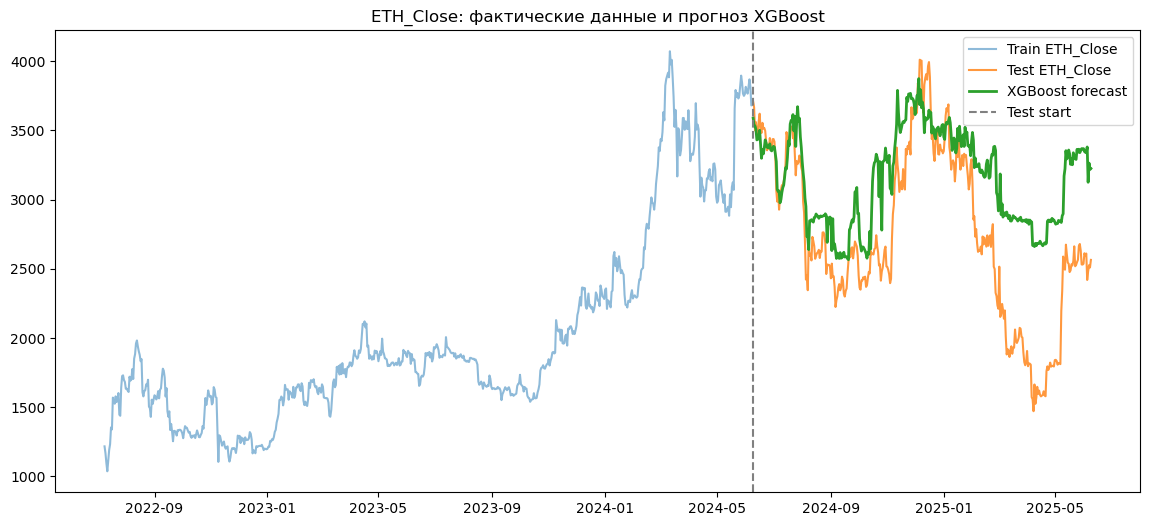

In [19]:
pred_series = pd.Series(y_pred, index=y_test.index, name='pred')

plt.plot(y_train.index, y_train, label='Train ETH_Close', alpha=0.5)
plt.plot(y_test.index, y_test, label='Test ETH_Close', alpha=0.8)
plt.plot(pred_series.index, pred_series, label='XGBoost forecast', linewidth=2)

plt.axvline(x=test_start_date, color='grey', linestyle='--', label='Test start')
plt.title('ETH_Close: фактические данные и прогноз XGBoost')
plt.legend()
plt.show()


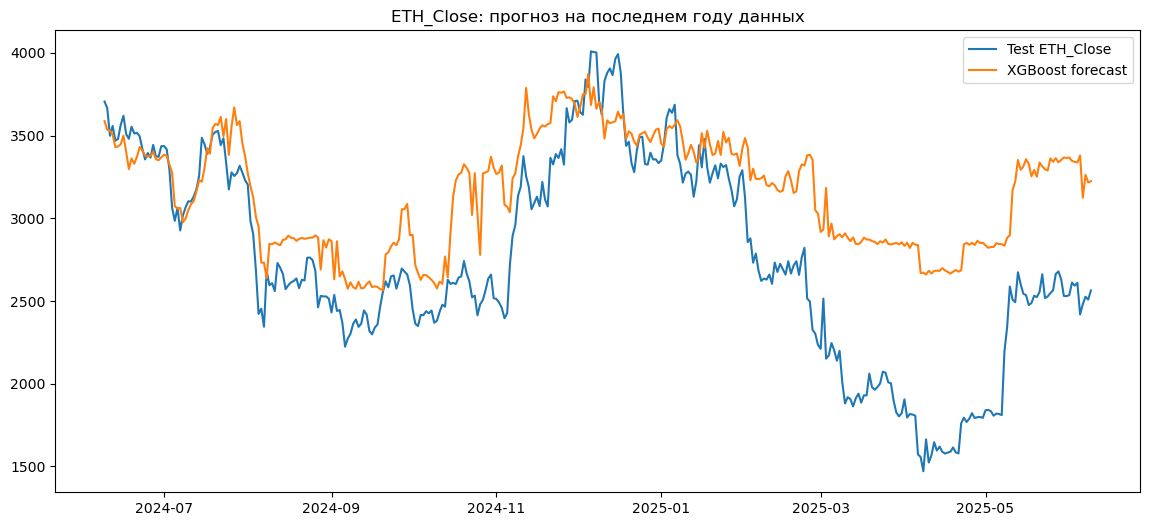

In [20]:
plt.plot(y_test.index, y_test, label='Test ETH_Close')
plt.plot(pred_series.index, pred_series, label='XGBoost forecast')
plt.title('ETH_Close: прогноз на последнем году данных')
plt.legend()
plt.show()